In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import seaborn as sns
from itertools import chain
#only needed  in development
import importlib # use like this: importlib.reload(typing_comparison.utils)

In [4]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [5]:
sample="HTAPP-783-SMP-4081"

In [6]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq",'exseq','exseq_bin','codex'] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
he_method="HE_highres"
all_methods=[sc_method,*sm_methods,he_method]
all_methods

['scRNAseq', 'slide_seq', 'exseq', 'exseq_bin', 'codex', 'HE_highres']

In [7]:
out_dir=out_dir_base+sample
os.makedirs(out_dir, exist_ok=True)

## Align and prep data

In [8]:
#get the data without processing (Filter: min_genes=30 min_cells=3 but further reduce low count obs if more than 35%)
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods,process=False)

reading  scRNAseq  from buffer
reading  slide_seq  from buffer
reading  exseq  from buffer
reading  exseq_bin  from buffer
reading  codex  from buffer
Loading processed HE_highres
Loading processed HE_highres


In [9]:
#select colors for single cell
sel_colors=colors[colors.index.isin(adatas[sc_method].obs[ct_column])]
adatas[sc_method].obs[ct_column]=pd.Categorical(adatas[sc_method].obs[ct_column], categories=sel_colors.index,ordered=True)
adatas[sc_method].uns[ct_column+"_colors"]=list(sel_colors.values)

In [39]:
#Note: the pre-applied HE scaling factor is 0.4 per default. Take this into account to align to a differently scaled HE. 

registration=pd.DataFrame(index=[i for i in list(replicate_splitter(adatas).index) if not (sc_method in i)] , 
                          columns=["crop_left","crop_right","crop_top","crop_bottom","scale","shift_x","shift_y","degrees","flip"])
#HE 1
registration.loc["HE 1","crop_left"]=0
registration.loc["HE 1","crop_right"]=0
registration.loc["HE 1","crop_top"]=0
registration.loc["HE 1","crop_bottom"]=0
registration.loc["HE 1","scale"]=0.6905#0.63
registration.loc["HE 1","degrees"]=-90

#HE 2
registration.loc["HE 2","crop_left"]=250
registration.loc["HE 2","crop_right"]=0
registration.loc["HE 2","crop_top"]=0
registration.loc["HE 2","crop_bottom"]=0
registration.loc["HE 2","scale"]=0.6905#0.63
registration.loc["HE 2","degrees"]=-92

#Annotation HE 1
registration.loc["HE 1 annot","crop_left"]=0
registration.loc["HE 1 annot","crop_right"]=0
registration.loc["HE 1 annot","crop_top"]=0
registration.loc["HE 1 annot","crop_bottom"]=0
registration.loc["HE 1 annot","scale"]=registration.loc["HE 1","scale"]/0.63
registration.loc["HE 1 annot","degrees"]=0


#Annotation HE 2
registration.loc["HE 2 annot","crop_left"]=0
registration.loc["HE 2 annot","crop_right"]=0
registration.loc["HE 2 annot","crop_top"]=0
registration.loc["HE 2 annot","crop_bottom"]=0
registration.loc["HE 2 annot","scale"]=registration.loc["HE 2","scale"]/0.63
registration.loc["HE 2 annot","degrees"]=0

#slide_seq 1
registration.loc["slide_seq 1","shift_x"]=300
registration.loc["slide_seq 1","shift_y"]=6100
registration.loc["slide_seq 1","degrees"]=0

#slide_seq 2
registration.loc["slide_seq 2","shift_x"]=350
registration.loc["slide_seq 2","shift_y"]=6300
registration.loc["slide_seq 2","degrees"]=1

#exseq 1
registration.loc["exseq 1","shift_x"]=290
registration.loc["exseq 1","shift_y"]=7750
registration.loc["exseq 1","degrees"]=56
registration.loc["exseq 1","flip"]="v"

#exseq_bin 1
registration.loc["exseq_bin 1","shift_x"]=290
registration.loc["exseq_bin 1","shift_y"]=7750
registration.loc["exseq_bin 1","degrees"]=56
registration.loc["exseq_bin 1","flip"]="v"

#codex 1
registration.loc["codex 1","shift_x"]=170
registration.loc["codex 1","shift_y"]=6550
registration.loc["codex 1","degrees"]=180

reg_file=out_dir+"/"+sample+"_registration.csv"
if os.path.isfile(reg_file)&False:
    print("Reading registation.")
    registration=pd.read_csv(reg_file,index_col=0)
else:
    print("Writing registration.")
    registration.to_csv(reg_file)

Writing registration.


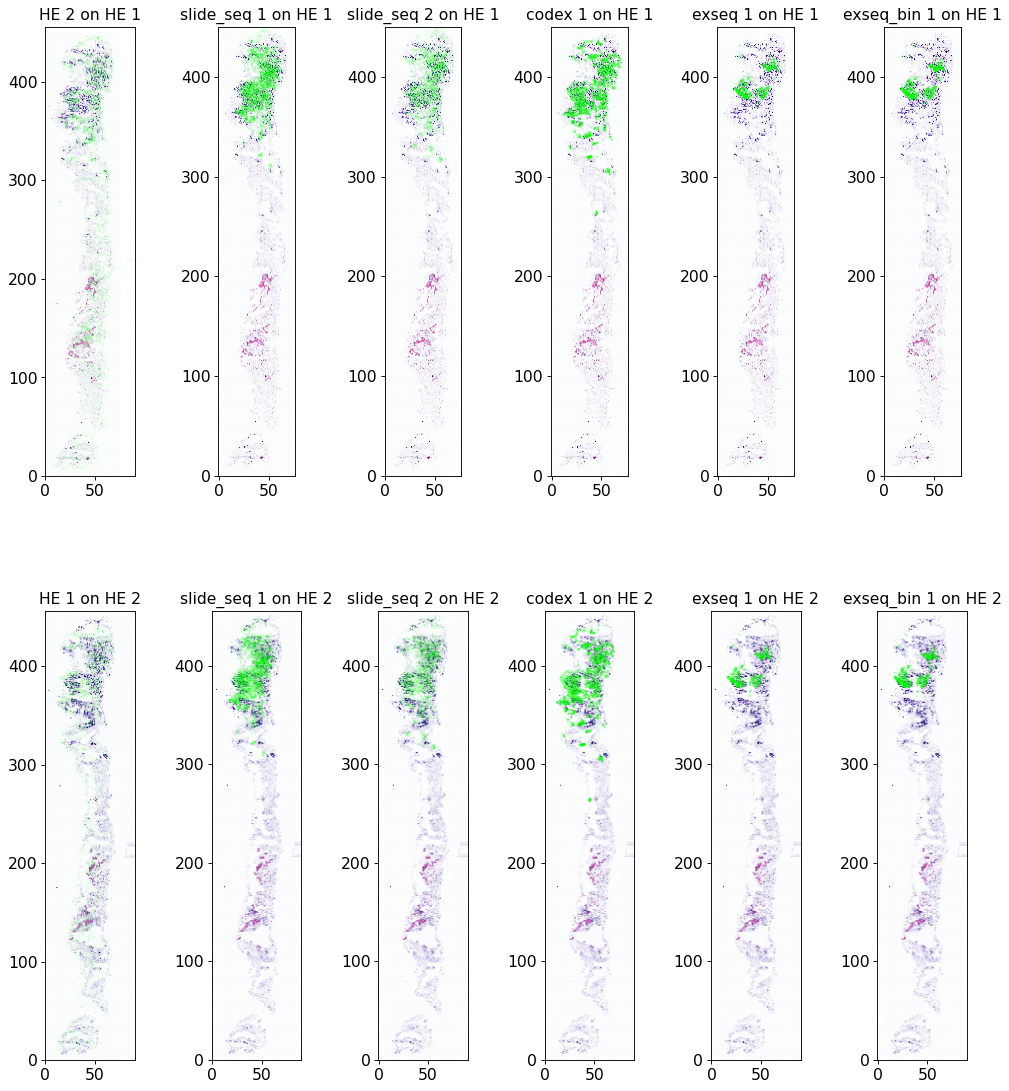

In [44]:
aligner(adatas,img_idx="HE 1",img_idx2="HE 2",dat_idxs=["slide_seq 1","slide_seq 2",'codex 1',"exseq 1","exseq_bin 1"],registration=registration,figsize=(16,17),dot_sizes=0.5,adjust=False,change=False)

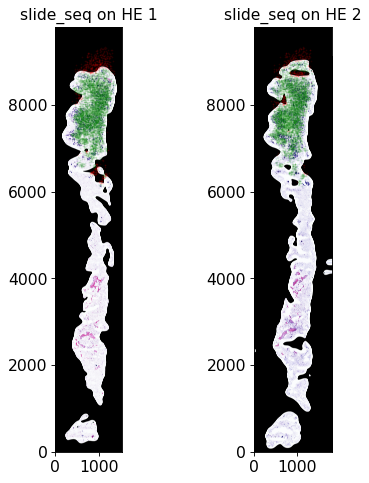

In [14]:
create_mask(adatas, ["HE 1","HE 2"],dat_idxs=["slide_seq"],figsize=(6,7),dot_sizes=[0.1],s=55,t=0.97)

In [48]:
add_annotations(adatas,sample,dat_idxs=["slide_seq","codex","exseq","exseq_bin"],registration=registration)

Fibrosis
AcellularDebris
Tumor
ImmuneCells
Tumor
AcellularDebris
ImmuneCells
Fibrosis


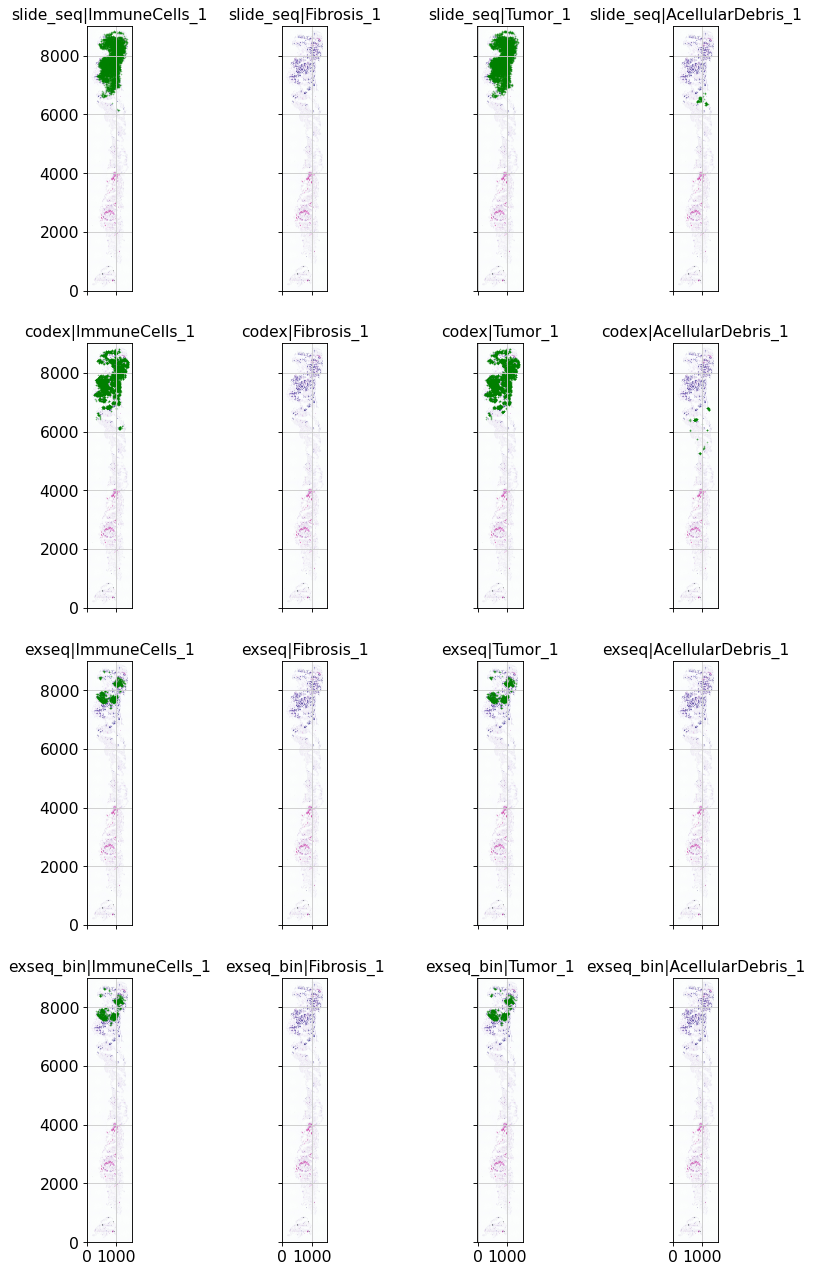

In [49]:
plot_annnotation(adatas,dat_idxs=["slide_seq","codex","exseq","exseq_bin"],annots=["ImmuneCells_1","Fibrosis_1","Tumor_1","AcellularDebris_1"],HE="HE 1",figsize=[12,20],s=0.05)

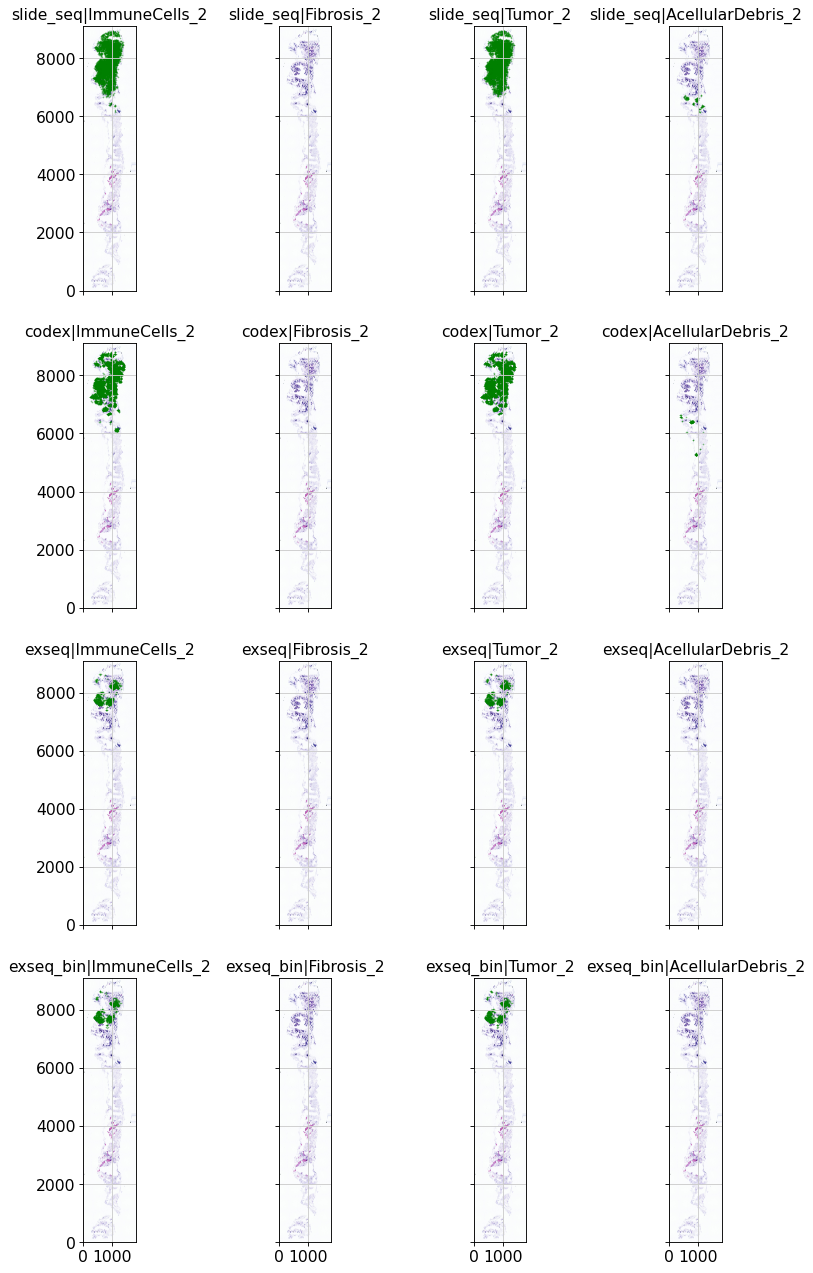

In [50]:
plot_annnotation(adatas,dat_idxs=["slide_seq","codex","exseq","exseq_bin"],annots=["ImmuneCells_2","Fibrosis_2","Tumor_2","AcellularDebris_2"],HE="HE 2",figsize=[12,20],s=0.05)

In [19]:
adatas=update_processed_adatas(adatas,sample,out_dir,all_methods,overwrite=True,process=True)

Processing scRNAseq
No HE masks found. Not trimming data.


Trying to set attribute `.obs` of view, copying.


Processing slide_seq
Batch aware HVG selection failed. Running without batch_key.
Processing codex
No HE masks found. Not trimming data.
Normalization turned off.


In [51]:
adatas=update_processed_adatas(adatas,sample,out_dir,["exseq","exseq_bin"],overwrite=True,process=True)

Processing exseq
No HE masks found. Not trimming data.
Processing exseq_bin
No HE masks found. Not trimming data.


## Load the processed data

In [52]:
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods)

reading  scRNAseq  from buffer
reading  slide_seq  from buffer
reading  exseq  from buffer
reading  exseq_bin  from buffer
reading  codex  from buffer
Loading processed HE_highres
Loading processed HE_highres


## Look at the data

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


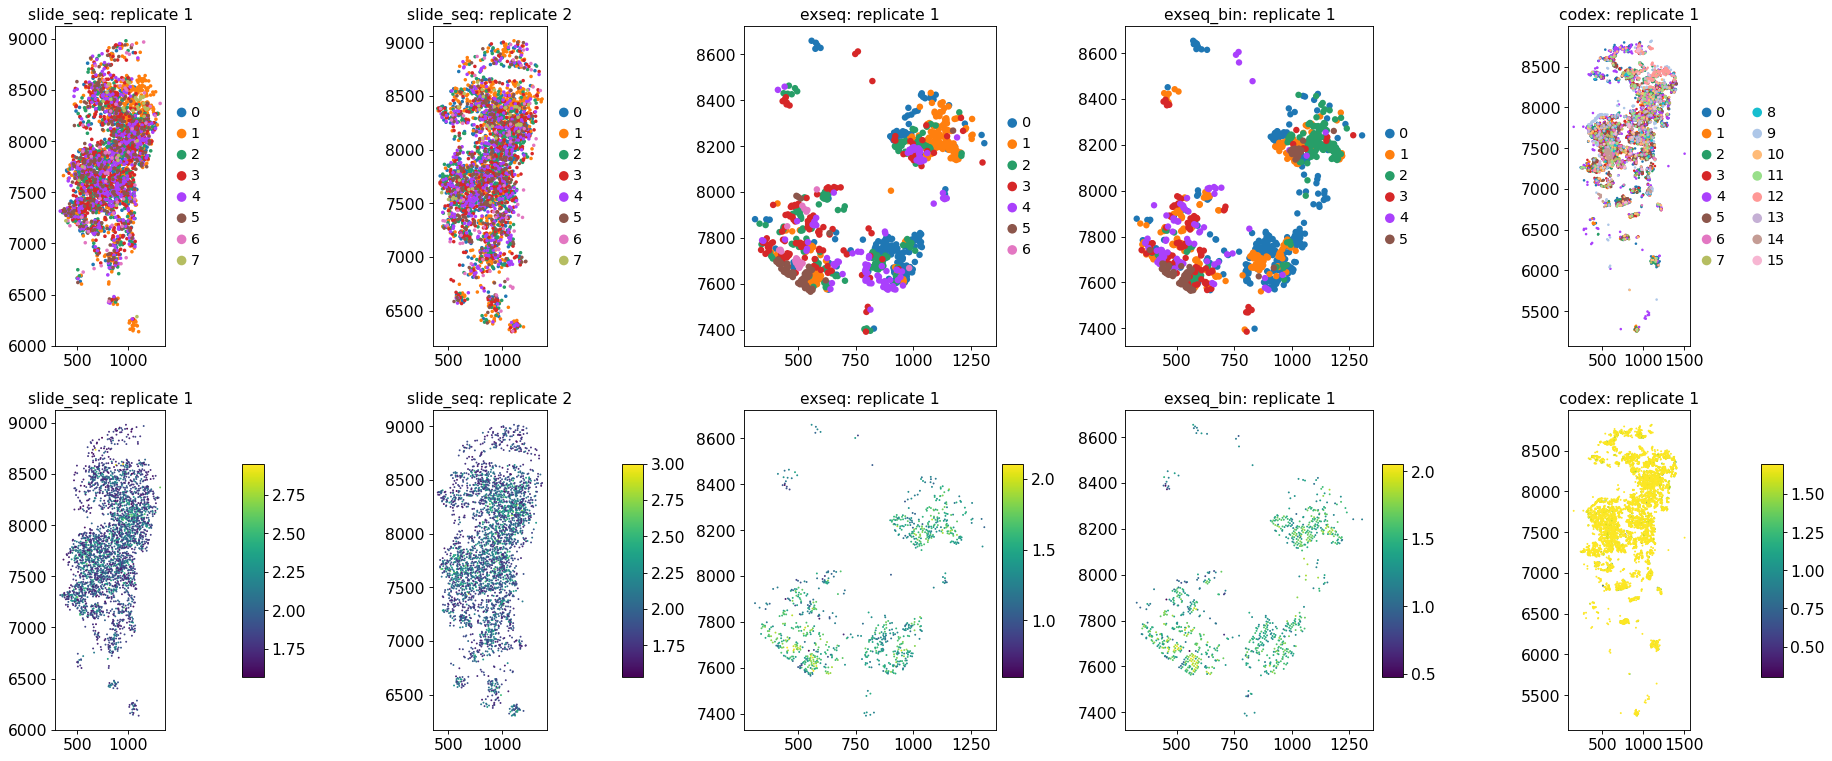

In [63]:
plot_spatial_obs(adatas,sm_methods,axsize=(4,4),wspace=0.06,x_shifts=[0,-0.025])

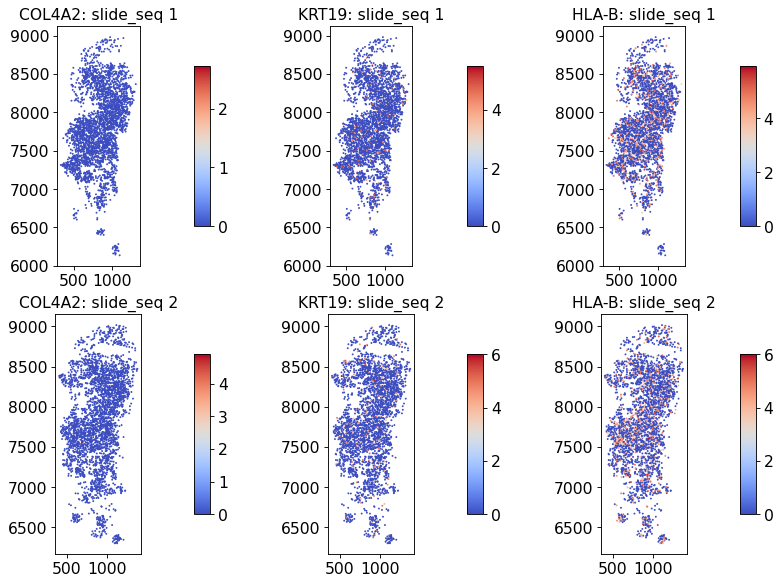

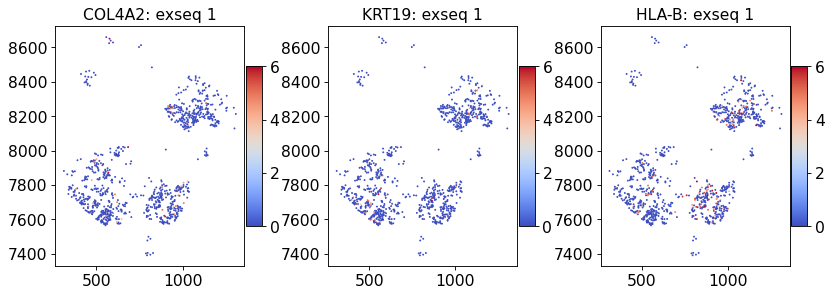

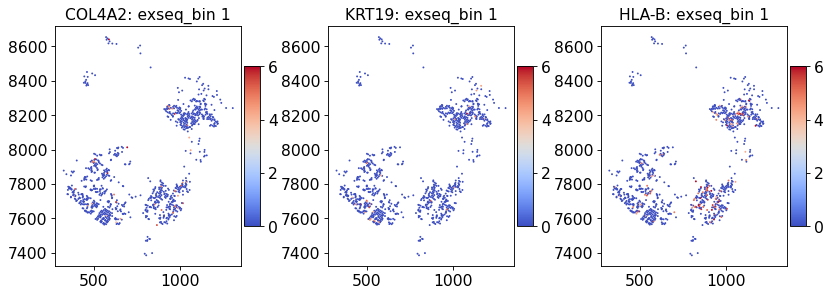

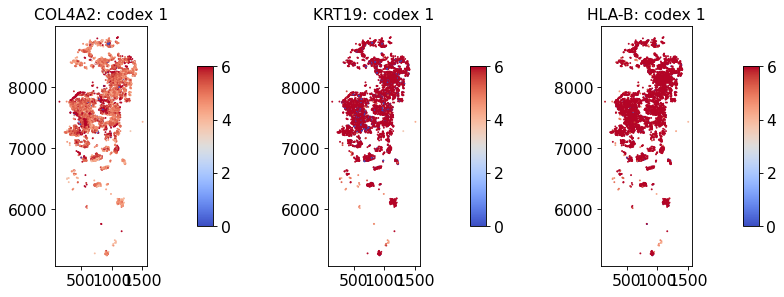

In [72]:
plot_spatial_genes(adatas,methods=sm_methods,genes = ["COL4A2","KRT19","HLA-B"],axsize=(3,3),wspace=0.035,x_shifts=[0,-0.04]);

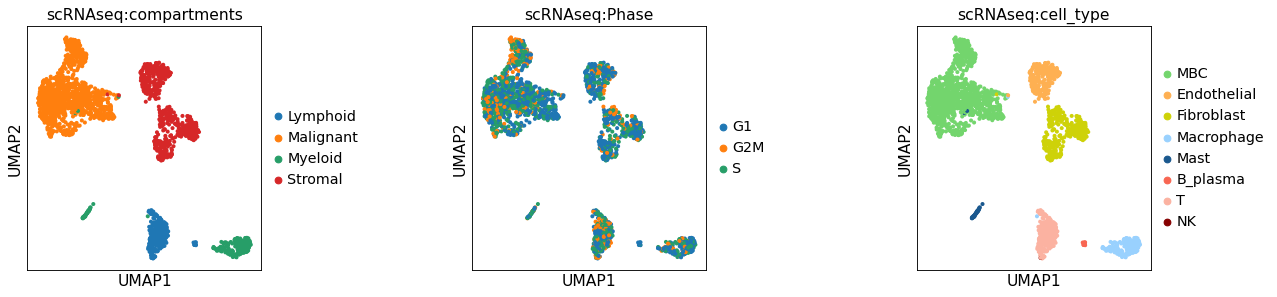

In [28]:
plot_variable_individual(adatas,method_vars=[("scRNAseq","compartments"),("scRNAseq","Phase"),("scRNAseq","cell_type")])

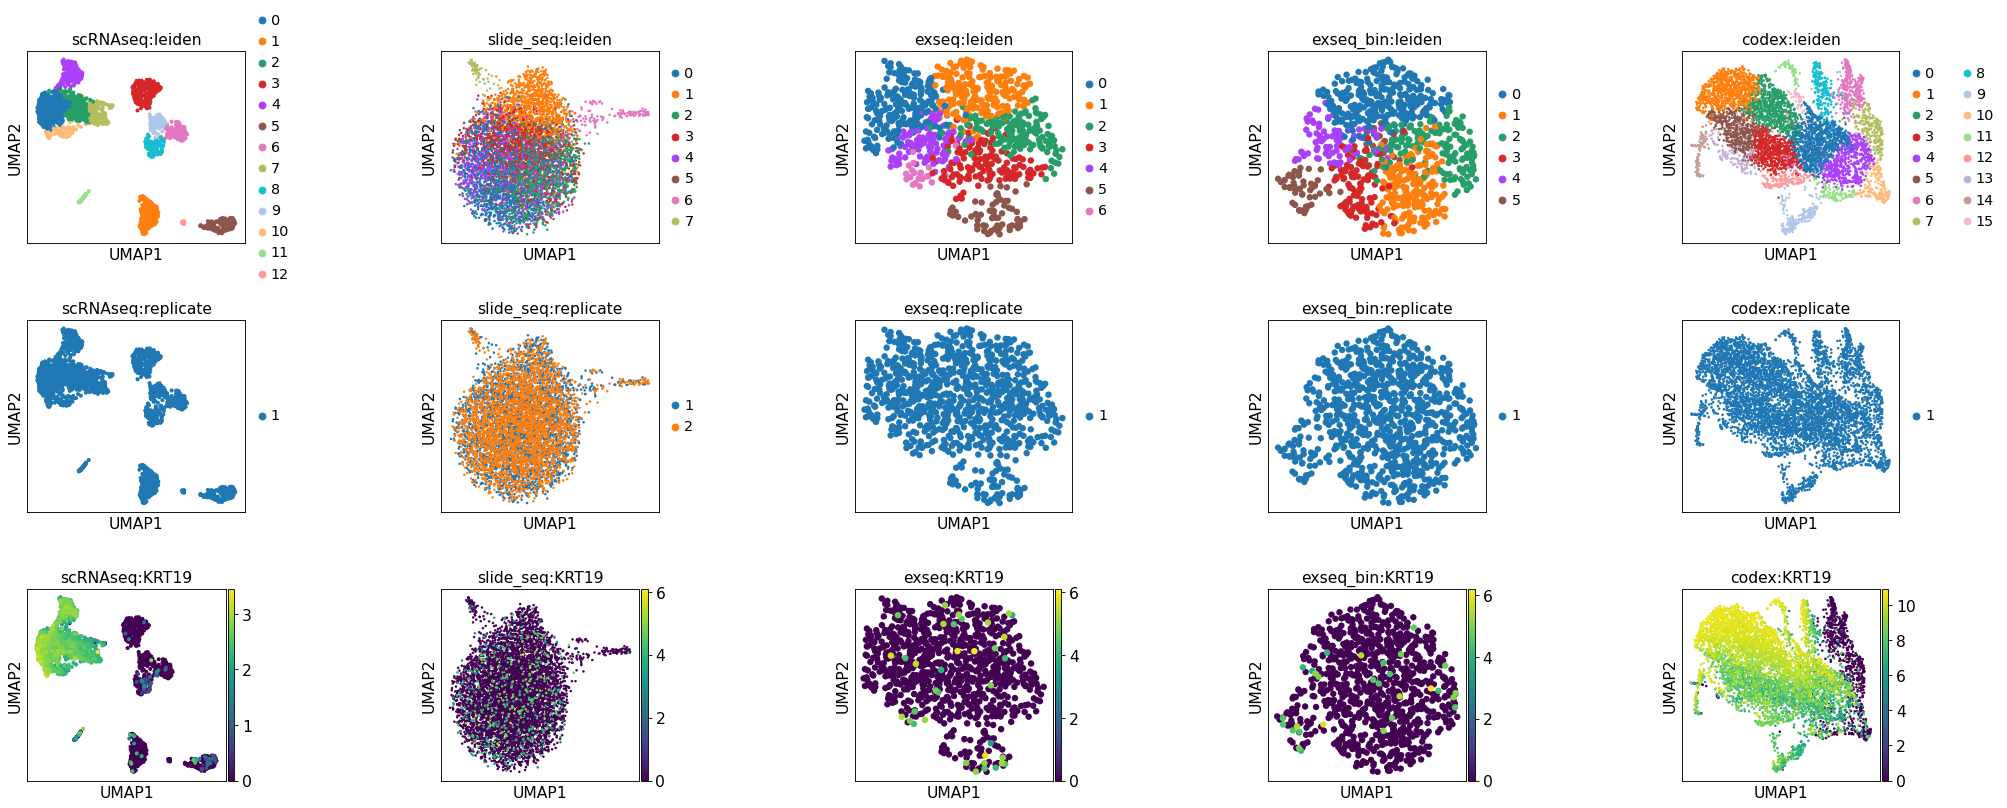

In [73]:
plot_variable_grid(adatas,methods=[sc_method,*sm_methods],variables=['leiden','replicate','KRT19'])

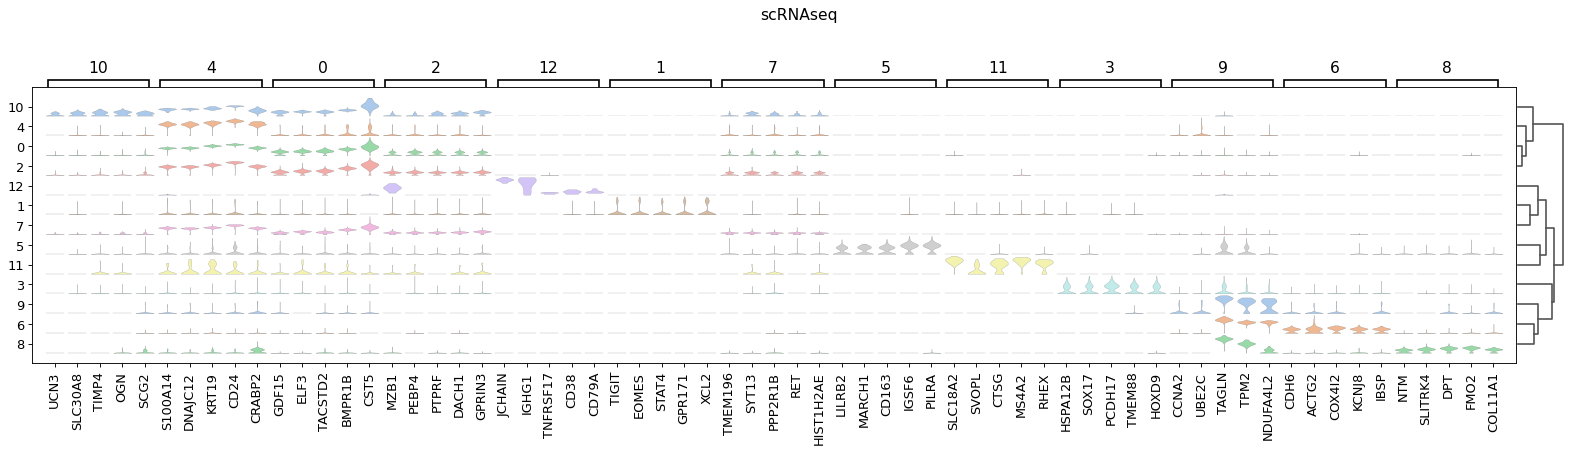

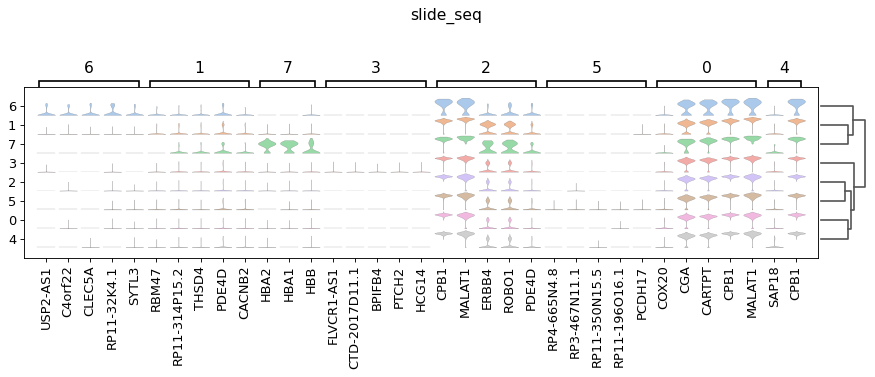

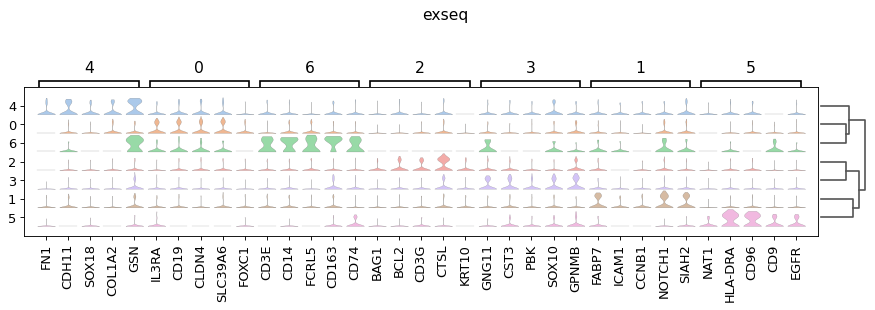

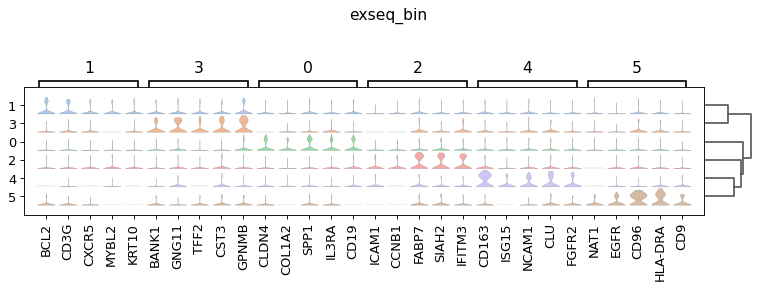

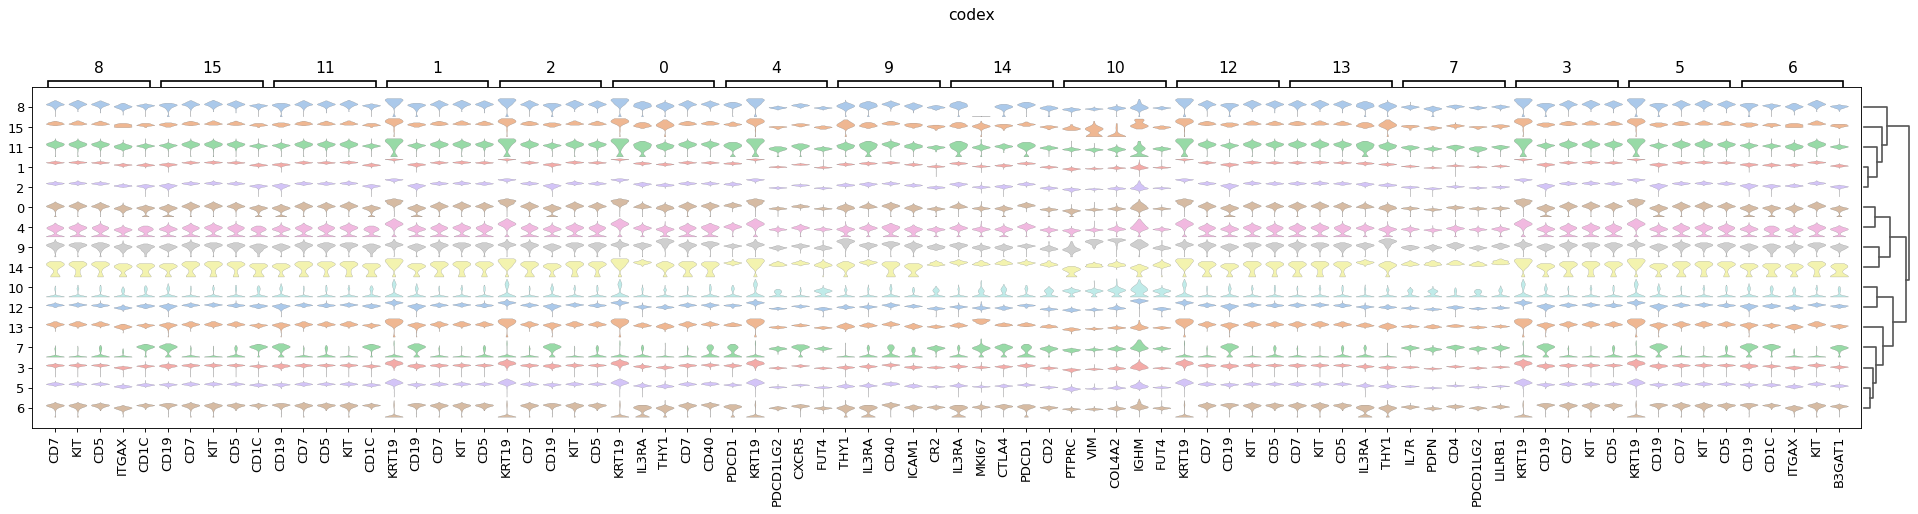

In [74]:
get_sub_markers(adatas,methods=[sc_method,*sm_methods],rest_thres=1)